In [91]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.stats import mode
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold
from MoleculeACE import MPNN, Data, Descriptors, \
                        calc_rmse, calc_cliff_rmse, get_benchmark_config

In [117]:
integrated_data = pd.read_csv('Integrated_dataset/integrated_data.csv')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27716\2220156028.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  integrated_data = pd.read_csv('Integrated_dataset/integrated_data.csv')


In [113]:
compounds = integrated_data['SMILES'].value_counts().index.tolist()
protein = integrated_data['UniProt_ID'].value_counts().index.tolist()
print('Number of compounds: ', len(compounds))
print('Number of proteins: ', len(protein))
print('Number of CPIs: ', len(integrated_data))

Number of compounds:  934824
Number of proteins:  6508
Number of CPIs:  2426682


In [118]:
# split data by activity type
integrated_ki = integrated_data[integrated_data['Activity_Type']=='pKi']
integrated_kd = integrated_data[integrated_data['Activity_Type']=='pKd']
integrated_ic50 = integrated_data[integrated_data['Activity_Type']=='pIC50']
integrated_ec50 = integrated_data[integrated_data['Activity_Type']=='pEC50']

In [119]:
def check_filter_conflicts(df, threshold, aggregation='mean'):
    """
    Check if there are conflicts in the data.
    params:
        df: DataFrame. Should contain columns 'UniProt_ID', 'SMILES', 'Activity_Value' and 'Activity_Type'.
        threshold: float. Default: 1.0 based on papyrus paper.
        aggregation: str. Default: 'mean'. Either 'mean' or 'mode'.
    return:
        df: DataFrame
        aggregated_df: DataFrame
    """
    
    df['is_conflict'] = 0
    
    for _, group in df.groupby('UniProt_ID'):
        for smiles, smiles_group in group.groupby('SMILES'):
            if len(smiles_group) > 1:
                max_diff = abs(smiles_group['Activity_Value'].diff().max())
                if max_diff >= threshold:
                    df.loc[smiles_group.index, 'is_conflict'] = 1

    filtered_df = df[df['is_conflict'] == 0].copy()
    
    if aggregation == 'mean':
        aggregated_df = filtered_df.groupby(['UniProt_ID', 'SMILES']).agg(
            activity_value=('Activity_Value', 'mean')
        ).reset_index()
    elif aggregation == 'mode':
        aggregated_df = filtered_df.groupby(['UniProt_ID', 'SMILES']).apply(
            lambda x: mode(x['Activity_Value'])[0][0]
        ).reset_index()
    else:
        raise ValueError("Aggregation method should be either 'mean' or 'mode'.")
    aggregated_df.columns = ['UniProt_ID', 'SMILES', 'Activity_Value']

    return df, aggregated_df

In [120]:
integrated_ki, new_ki = check_filter_conflicts(integrated_ki, 1, 'mean')
integrated_kd, new_kd = check_filter_conflicts(integrated_kd, 1, 'mean')
integrated_ic50, new_ic50 = check_filter_conflicts(integrated_ic50, 1, 'mean')
integrated_ec50, new_ec50 = check_filter_conflicts(integrated_ec50, 1, 'mean')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27716\2937848518.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_conflict'] = 0
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27716\2937848518.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_conflict'] = 0
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27716\2937848518.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def plot_overlap(df1, df2, title):
    """
    Plot the overlap between two datasets.
    params:
        df1: DataFrame. Should contain columns 'UniProt_ID', 'SMILES', 'Activity_Value' and 'Activity_Type'.
        df2: DataFrame. Should contain columns 'UniProt_ID', 'SMILES', 'Activity_Value' and 'Activity_Type'.
        title: str. Title of the plot.
    return:
        None
    """
    
    df1 = df1[['UniProt_ID', 'SMILES']].drop_duplicates()
    df2 = df2[['UniProt_ID', 'SMILES']].drop_duplicates()
    
    df1['in_df2'] = 1
    df2['in_df1'] = 1
    
    df = pd.merge(df1, df2, on=['UniProt_ID', 'SMILES'], how='outer')
    df = df.fillna(0)
    
    df['in_df1'] = df['in_df1'].astype(int)
    df['in_df2'] = df['in_df2'].astype(int)
    
    df = df.groupby(['in_df1', 'in_df2']).size().reset_index()
    df.columns = ['in_df1', 'in_df2', 'count']
    
    df['label'] = df['in_df1'].astype(str) + ' in df1, ' + df['in_df2'].astype(str) + ' in df2'
    
    fig = px.bar(df, x='label', y='count', title=title)
    fig.show()

In [135]:
def print_stat(df):
    """
    Print the statistics of the dataset.
    params:
        df: DataFrame. Should contain columns 'UniProt_ID', 'SMILES', 'Activity_Value' and 'Activity_Type'.
    return:
        None
    """
    
    print('Number of compounds: ', len(df['SMILES'].unique()))
    print('Number of proteins: ', len(df['UniProt_ID'].unique()))
    print('Number of CPIs: ', len(df))
    print('Number of activities: ', len(df['Activity_Value'].unique()))
    print('Activity range: ', df['Activity_Value'].min(), df['Activity_Value'].max())
    print('Activity mean: ', df['Activity_Value'].mean())
    print('Activity std: ', df['Activity_Value'].std())

In [142]:
new_ki['Activity_Type'] = 'pKi'
new_kd['Activity_Type'] = 'pKd'
new_ic50['Activity_Type'] = 'pIC50'
new_ec50['Activity_Type'] = 'pEC50'
integrated_new = pd.concat([new_ki, new_kd, new_ic50, new_ec50], ignore_index=True)
print_stat(integrated_new)

Number of compounds:  928950
Number of proteins:  6508
Number of CPIs:  1968946
Number of activities:  11928
Activity range:  0.1 18.0
Activity mean:  6.337825926014173
Activity std:  1.4687441145426805


In [143]:
cutoff_protein = 300
protein_list = integrated_new['UniProt_ID'].value_counts()[
                integrated_new['UniProt_ID'].value_counts() >= cutoff_protein].index.tolist()
integrated_plus = integrated_new[integrated_new['UniProt_ID'].isin(protein_list)]
print_stat(integrated_plus)

Number of compounds:  851066
Number of proteins:  1075
Number of CPIs:  1783818
Number of activities:  11788
Activity range:  0.1 18.0
Activity mean:  6.368151571547795
Activity std:  1.4709685010731655


In [144]:
print_stat(integrated_plus[integrated_plus['Activity_Type']=='pKi'])
print('----------------')
print_stat(integrated_plus[integrated_plus['Activity_Type']=='pKd'])
print('----------------')
print_stat(integrated_plus[integrated_plus['Activity_Type']=='pIC50'])
print('----------------')
print_stat(integrated_plus[integrated_plus['Activity_Type']=='pEC50'])

Number of compounds:  195647
Number of proteins:  909
Number of CPIs:  487971
Number of activities:  4300
Activity range:  0.1 13.854
Activity mean:  6.64652732567896
Activity std:  1.4505253199677326
----------------
Number of compounds:  13735
Number of proteins:  703
Number of CPIs:  37126
Number of activities:  2181
Activity range:  0.1 13.481
Activity mean:  6.191698355441787
Activity std:  1.525458045458144
----------------
Number of compounds:  613008
Number of proteins:  1062
Number of CPIs:  1117188
Number of activities:  10540
Activity range:  0.1 18.0
Activity mean:  6.278143715088436
Activity std:  1.4602367906197482
----------------
Number of compounds:  91767
Number of proteins:  699
Number of CPIs:  141533
Number of activities:  3089
Activity range:  0.1 15.9
Activity mean:  6.165141701935237
Activity std:  1.481445282067574


In [145]:
new_ki = new_ki[new_ki['UniProt_ID'].isin(protein_list)]
new_kd = new_kd[new_kd['UniProt_ID'].isin(protein_list)]
new_ic50 = new_ic50[new_ic50['UniProt_ID'].isin(protein_list)]
new_ec50 = new_ec50[new_ec50['UniProt_ID'].isin(protein_list)]

In [132]:
integrated_plus.to_csv('Integrated_dataset/integrated_plus.csv', index=False)

In [134]:
compounds = integrated_plus['SMILES'].value_counts().index.tolist()
protein = integrated_plus['UniProt_ID'].value_counts().index.tolist()
print('Number of compounds: ', len(compounds))
print('Number of proteins: ', len(protein))
print('Number of CPIs: ', len(integrated_plus))

Number of compounds:  851066
Number of proteins:  1075
Number of CPIs:  1783818


In [ ]:
def cal_ecfp4_sim_matrix(smiles_list):
    """
    Calculate ECFP4 similarity matrix for a list of smiles.
    param 
        smiles_list: list of smiles
    return
        similarity_matrix: similarity matrix
    """
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2)
                     for smiles in smiles_list]
    
    n = len(smiles_list)
    similarity_matrix = np.zeros((n, n), dtype=np.float32)
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                sim = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
                similarity_matrix[i, j] = round(sim, 3)
                similarity_matrix[j, i] = round(sim, 3)
            
    return similarity_matrix


def cal_scaffold_sim_matrix(smiles_list):
    """
    Calculate Scaffold similarity matrix for a list of smiles.
    param 
        smiles_list: list of smiles
    return
        similarity_matrix: similarity matrix    
    """

    scaffolds = []
    for smiles in smiles_list:
        try:
            scaffolds.append(MurckoScaffold.GetScaffoldForMol(Chem.MolFromSmiles(smiles)))
        except:
            scaffolds.append(Chem.MolFromSmiles(smiles))
            print(f'{smiles} can not be converted to scaffold, take the original molecule instead.')
        pass
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(scaffold, 2) 
                    for scaffold in scaffolds]
    
    n = len(smiles_list)
    similarity_matrix = np.zeros((n, n), dtype=np.float32)
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                sim = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
                similarity_matrix[i, j] = round(sim, 3)
                similarity_matrix[j, i] = round(sim, 3)
            
    return similarity_matrix

def jaccard_similarity(str1, str2):

    set1 = set(str1)
    set2 = set(str2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)

    return intersection / union

def cal_smiles_sim_matrix(smiles_list):
    """
    Calculate Sequence similarity matrix for a list of smiles
    param 
        smiles_list: list of smiles
    return
        similarity_matrix: similarity matrix
    """

    n = len(smiles_list)
    similarity_matrix = np.zeros((n, n), dtype=np.float16)
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                sim = jaccard_similarity(smiles_list[i], smiles_list[j])
                similarity_matrix[i, j] = round(sim, 3)
                similarity_matrix[j, i] = round(sim, 3)
                
    return similarity_matrix

def cal_sim_target_set(df):
    """
    Calculate similarity matrix for each target
    param 
        df: dataframe with columns ['UniProt_ID', 'SMILES']
    return
        target_sim_dict: dict with key as target and value as
        [smiles_list, ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix]
    """

    target_list = list(df['UniProt_ID'].value_counts().index)
    target_sim_dict = {}
    print('Processing similarity matrix for each target...')
    for target in tqdm(target_list):
        subset = df[df['UniProt_ID']==target]
        if subset.shape[0] > 1:
            smiles_list = subset['SMILES'].unique()
            target_sim_dict[target] = [smiles_list]  
            target_sim_dict[target].append(cal_ecfp4_sim_matrix(smiles_list))
            target_sim_dict[target].append(cal_scaffold_sim_matrix(smiles_list))
            target_sim_dict[target].append(cal_smiles_sim_matrix(smiles_list))
    return target_sim_dict

def save_dict(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [146]:
# calculate similarity matrix for each target in ki dataset
ki_target_sim_dict = cal_sim_target_set(new_ki)
if not os.path.exists('Integrated_dataset/sim_matrix'):
    os.mkdir('Integrated_dataset/sim_matrix')
save_dict(ki_target_sim_dict, 'Integrated_dataset/sim_matrix/ki_target')

Processing similarity matrix for each target...


  0%|          | 0/909 [00:00<?, ?it/s]

[21:56:29] Unusual charge on atom 16 number of radical electrons set to zero
[21:57:31] Unusual charge on atom 16 number of radical electrons set to zero
[21:59:44] Unusual charge on atom 16 number of radical electrons set to zero
[22:00:41] Unusual charge on atom 16 number of radical electrons set to zero
[22:11:08] Unusual charge on atom 16 number of radical electrons set to zero
[22:11:35] Unusual charge on atom 16 number of radical electrons set to zero
[22:21:18] Unusual charge on atom 16 number of radical electrons set to zero
[22:21:35] Unusual charge on atom 16 number of radical electrons set to zero
[22:33:48] Unusual charge on atom 16 number of radical electrons set to zero
[22:33:50] Unusual charge on atom 16 number of radical electrons set to zero
[22:34:35] Unusual charge on atom 16 number of radical electrons set to zero
[22:34:37] Unusual charge on atom 16 number of radical electrons set to zero
[22:42:02] Unusual charge on atom 16 number of radical electrons set to zero

In [147]:
# calculate similarity matrix for each target in kd dataset
kd_target_sim_dict = cal_sim_target_set(new_kd)
if not os.path.exists('Integrated_dataset/sim_matrix'): 
    os.mkdir('Integrated_dataset/sim_matrix')
save_dict(kd_target_sim_dict, 'Integrated_dataset/sim_matrix/kd_target')

Processing similarity matrix for each target...


  0%|          | 0/703 [00:00<?, ?it/s]

In [148]:
# calculate similarity matrix for each target in ic50 dataset
ic50_target_sim_dict = cal_sim_target_set(new_ic50)
if not os.path.exists('Integrated_dataset/sim_matrix'): 
    os.mkdir('Integrated_dataset/sim_matrix')
save_dict(ic50_target_sim_dict, 'Integrated_dataset/sim_matrix/ic50_target')

Processing similarity matrix for each target...


  0%|          | 0/1062 [00:00<?, ?it/s]

[00:09:43] Explicit valence for atom # 0 C greater than permitted


C[C+](=O)(Nc1ccccc1)C(C#N)=Cc1ccc(O)c(O)c1 can not be converted to scaffold, take the original molecule instead.


In [149]:
# calculate similarity matrix for each target in ec50 dataset
ec50_target_sim_dict = cal_sim_target_set(new_ec50)
if not os.path.exists('Integrated_dataset/sim_matrix'):
    os.mkdir('Integrated_dataset/sim_matrix')
save_dict(ec50_target_sim_dict, 'Integrated_dataset/sim_matrix/ec50_target')

Processing similarity matrix for each target...


  0%|          | 0/699 [00:00<?, ?it/s]

In [150]:
print(f'Ki dataset: {len(new_ki)}, number of protein: {len(new_ki["UniProt_ID"].unique())}')
print(f'Kd dataset: {len(new_kd)}, number of protein: {len(new_kd["UniProt_ID"].unique())}')
print(f'IC50 dataset: {len(new_ic50)}, number of protein: {len(new_ic50["UniProt_ID"].unique())}')
print(f'EC50 dataset: {len(new_ec50)}, number of protein: {len(new_ec50["UniProt_ID"].unique())}')
print(f'Sum of all datasets: {len(new_ki)+len(new_kd)+len(new_ic50)+len(new_ec50)}, '
      f'number of protein: {len(integrated_data["UniProt_ID"].unique())}')

Ki dataset: 487971, number of protein: 909
Kd dataset: 37126, number of protein: 703
IC50 dataset: 1117188, number of protein: 1062
EC50 dataset: 141533, number of protein: 699
Sum of all datasets: 1783818, number of protein: 6508


In [151]:
def extract_mmp(sim_mat1, sim_mat2, sim_mat3, threshold=0.9):
    """
    Extract matched molecular pairs from three similarity matrices.
    param
        sim_mat1: similarity matrix 1
        sim_mat2: similarity matrix 2
        sim_mat3: similarity matrix 3
        threshold: similarity threshold
    """

    assert sim_mat1.shape == sim_mat2.shape == sim_mat3.shape, "All matrices must have the same shape."
    
    pairs = []
    n, m = sim_mat1.shape
    for i in range(n):
        for j in range(i+1, m):
            if sim_mat1[i, j] > threshold or sim_mat2[i, j] > threshold or sim_mat3[i, j] > threshold:
                pairs.append((i, j))     
                          
    return pairs

def compare_activity_values(df, pairs):
    """
    Compare activity values for each pair of molecules.
    param:
        df: dataframe with columns ['smiles', 'activity_value']
        pairs: list of pairs of molecules
    return:
        dataframe with columns ['start_index', 'end_index', 'start_smiles', 'end_smiles',
                                'start_activity_value', 'end_activity_value', 'label']
    """
    
    data = {
        'UniProt_ID': [],
        'start_index': [],
        'end_index': [],
        'start_smiles': [],
        'end_smiles': [],
        'start_activity_value': [],
        'end_activity_value': [],
        'label': []
    }
    smiles_list = df['SMILES'].unique()
    smiles_activity = dict(zip(df['SMILES'], df['Activity_Value']))
    target = df['UniProt_ID'].unique()[0]

    for i, j in pairs:
        start_smiles = smiles_list[i]
        end_smiles = smiles_list[j]
        start_activity_value = smiles_activity[start_smiles]
        end_activity_value = smiles_activity[end_smiles]

        label = 1 if abs(start_activity_value - end_activity_value) >= 2 else 0
        
        data['UniProt_ID'].append(target)
        data['start_index'].append(i)
        data['end_index'].append(j)
        data['start_smiles'].append(start_smiles)
        data['end_smiles'].append(end_smiles)
        data['start_activity_value'].append(start_activity_value)
        data['end_activity_value'].append(end_activity_value)
        data['label'].append(label)
        
    return pd.DataFrame(data)


In [152]:
# extract mmps and mmp-activity cliffs for kd dataset
# ki_target_sim_dict = pickle.load(open('Integrated_dataset/sim_matrix/ki_target.pkl', 'rb'))
ac_ki = pd.DataFrame()
for protein in tqdm(new_ki['UniProt_ID'].unique()):
    if len(new_ki[new_ki['UniProt_ID']==protein]) < 2:
        continue
    smiles_list, ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix = ki_target_sim_dict[protein]
    pairs = extract_mmp(ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix, threshold=0.9)
    ac_ki = pd.concat([ac_ki, 
                       compare_activity_values(new_ki[new_ki['UniProt_ID']==protein], pairs)])
ac_ki.to_csv('Integrated_dataset/AC_ki.csv', index=False)

  0%|          | 0/909 [00:00<?, ?it/s]

In [153]:
# extract mmps and mmp-activity cliffs for kd dataset
kd_target_sim_dict = pickle.load(open('Integrated_dataset/sim_matrix/kd_target.pkl', 'rb'))
ac_kd = pd.DataFrame()
for protein in tqdm(new_kd['UniProt_ID'].unique()):
    if len(new_kd[new_kd['UniProt_ID']==protein]) < 2:
        continue
    smiles_list, ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix = kd_target_sim_dict[protein]
    pairs = extract_mmp(ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix, threshold=0.9)
    ac_kd = pd.concat([ac_kd, 
                       compare_activity_values(new_kd[new_kd['UniProt_ID']==protein], pairs)])
ac_kd.to_csv('Integrated_dataset/AC_kd.csv', index=False)

  0%|          | 0/703 [00:00<?, ?it/s]

In [154]:
# extract mmps and mmp-activity cliffs for ec50 dataset
ec50_target_sim_dict = pickle.load(open('Integrated_dataset/sim_matrix/ec50_target.pkl', 'rb'))
ac_ec50 = pd.DataFrame()
for protein in tqdm(new_ec50['UniProt_ID'].unique()):
    if len(new_ec50[new_ec50['UniProt_ID']==protein]) < 2:
        continue
    smiles_list, ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix = ec50_target_sim_dict[protein]
    pairs = extract_mmp(ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix, threshold=0.9)
    ac_ec50 = pd.concat([ac_ec50, 
                       compare_activity_values(new_ec50[new_ec50['UniProt_ID']==protein], pairs)])
ac_ec50.to_csv('Integrated_dataset/AC_ec50.csv', index=False)

  0%|          | 0/699 [00:00<?, ?it/s]

In [183]:
ac_ic50[ac_ic50['label'] == 1]['UniProt_ID'].value_counts()

UniProt_ID
P42336    1590412
Q13547     545489
Q16539     517357
P35968     430574
P00533     382910
           ...   
P25090          1
Q14012          1
Q8TDV5          1
P04757          1
Q932Y6          1
Name: count, Length: 1015, dtype: int64

In [182]:
ac_ic50['UniProt_ID'].value_counts()[ac_ic50['UniProt_ID'].value_counts() >= 300]

UniProt_ID
P42336    7923511
Q13547    2621926
P48736    2127894
P35968    1841336
Q16539    1836243
           ...   
O95264        320
Q70Z44        319
Q9UEE5        314
Q9Y5Y6        313
P04757        301
Name: count, Length: 1002, dtype: int64

In [173]:
del ac_ki, ac_kd, ac_ec50, ki_target_sim_dict, kd_target_sim_dict, ec50_target_sim_dict
del smiles_list, ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix, pairs

In [ ]:
# extract mmps and mmp-activity cliffs for ec50 dataset
ec50_target_sim_dict = pickle.load(open('Integrated_dataset/sim_matrix/ec50_target.pkl', 'rb'))
ac_ec50 = pd.DataFrame()
for protein in tqdm(new_ec50['UniProt_ID'].unique()):
    if len(new_ec50[new_ec50['UniProt_ID']==protein]) < 2:
        continue
    smiles_list, ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix = ec50_target_sim_dict[protein]
    pairs = extract_mmp(ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix, threshold=0.9)
    ac_ec50 = pd.concat([ac_ec50, 
                       compare_activity_values(new_ec50[new_ec50['UniProt_ID']==protein], pairs)])
ac_ec50.to_csv('Integrated_dataset/AC_ec50.csv', index=False)

In [177]:
# extract mmps and mmp-activity cliffs for ec50 dataset
# ic50_target_sim_dict = pickle.load(open('Integrated_dataset/sim_matrix/ic50_target.pkl', 'rb'))
ac_ic50 = pd.DataFrame()
for protein in tqdm(new_ic50['UniProt_ID'].unique()):
    if len(new_ic50[new_ic50['UniProt_ID']==protein]) < 2:
        continue
    smiles_list, ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix = ic50_target_sim_dict[protein]
    pairs = extract_mmp(ecfp4_sim_matrix, scaffold_sim_matrix, smiles_sim_matrix, threshold=0.9)
    ac_ic50 = pd.concat([ac_ic50, 
                       compare_activity_values(new_ic50[new_ic50['UniProt_ID']==protein], pairs)])
ac_ic50.to_csv('Integrated_dataset/AC_ic50.csv', index=False)

  0%|          | 0/1062 [00:00<?, ?it/s]

In [180]:
ac_ic50['label'].value_counts()

label
0.0    66334699
1.0    15027924
Name: count, dtype: int64

In [110]:
ac_kd['UniProt_ID'].value_counts()[ac_kd['UniProt_ID'].value_counts() > 500]

UniProt_ID
P00918    15961
P30556    15331
P50052    15038
P23944    10586
P43140     6785
          ...  
Q8VH26      532
Q9UGN5      529
Q16236      523
Q00987      510
P00338      509
Name: count, Length: 101, dtype: int64

In [ ]:
ac_ki = ac_ki.reset_index(drop=True)
ac_ki[ac_ki['label']==1]

,UniProt_ID,start_index,end_index,start_smiles,end_smiles,start_activity_value,end_activity_value,label
153,A0A1D8D5K2,1.0,5.0,CCCCN1C(=N)C(C(CC2CCCNC2=O)NC(=O)C(Cc2ccc(F)cc...,Cc1cc(C(=O)NC(Cc2ccc(F)cc2)C(=O)NC(CC2CCCNC2=O...,5.59,8.40,1.0
162,A0A1D8D5K2,4.0,5.0,Cc1cc(C(=O)NC(Cc2ccc(F)cc2)C(=O)NC(CC2CCCNC2=O...,Cc1cc(C(=O)NC(Cc2ccc(F)cc2)C(=O)NC(CC2CCCNC2=O...,6.25,8.40,1.0
179,A3EZI9,0.0,5.0,C=CC1CC1(NC(=O)C1CC2CN1C(=O)C(C(C)(C)C)NC(=O)O...,C=CC1CC1(NC(=O)C1CC2CN1C(=O)C(C1CCCCC1)NC(=O)O...,10.70,7.82,1.0
180,A3EZI9,0.0,7.0,C=CC1CC1(NC(=O)C1CC2CN1C(=O)C(C(C)(C)C)NC(=O)O...,C=CCCCS(=O)(=O)NC(=O)C(CCC)NC(=O)C1NC(=O)C(C(C...,10.70,5.80,1.0
181,A3EZI9,0.0,8.0,C=CC1CC1(NC(=O)C1CC2CN1C(=O)C(C(C)(C)C)NC(=O)O...,C=CCCCS(=O)(=O)NC(=O)c1ccccc1NC(=O)C(NC(=O)OC(...,10.70,6.66,1.0
...,...,...,...,...,...,...,...,...
25700154,Q9Z2W9,6.0,15.0,CNC(=O)Cn1c(=O)c(=O)[nH]c2cc(C(F)(F)F)c(-n3ccc...,O=C(O)Cn1c(=O)c(=O)[nH]c2cc([N+](=O)[O-])c(-n3...,4.70,7.16,1.0
25700165,Q9Z2W9,9.0,15.0,O=C(Cn1c(=O)c(=O)[nH]c2cc([N+](=O)[O-])c(-n3cc...,O=C(O)Cn1c(=O)c(=O)[nH]c2cc([N+](=O)[O-])c(-n3...,4.70,7.16,1.0
25700171,Q9Z2W9,10.0,15.0,O=C(Cn1c(=O)c(=O)[nH]c2cc([N+](=O)[O-])c(-n3cc...,O=C(O)Cn1c(=O)c(=O)[nH]c2cc([N+](=O)[O-])c(-n3...,4.70,7.16,1.0
25700191,Q9Z2W9,15.0,17.0,O=C(O)Cn1c(=O)c(=O)[nH]c2cc([N+](=O)[O-])c(-n3...,O=c1[nH]c2cc(-n3cccc3)c([N+](=O)[O-])cc2n(C2CC...,7.16,4.60,1.0


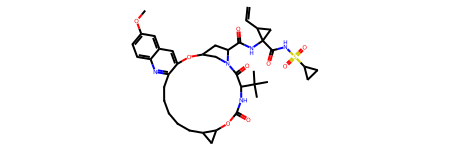

In [ ]:
from rdkit import Chem
Chem.MolFromSmiles(ac_ki.iloc[179]['start_smiles'])

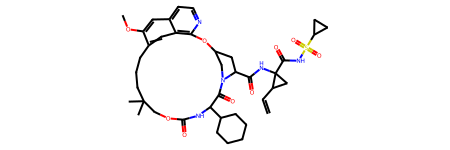

In [ ]:
Chem.MolFromSmiles(ac_ki.iloc[179]['end_smiles'])

In [ ]:
def load_smiles_from_pickle(file_name):
    with open(file_name, 'rb') as f:
        smiles = pickle.load(f)
    return smiles

smiles = load_smiles_from_pickle('Integrated_dataset/smiles_dict.pkl')